In [1]:
%load_ext autoreload
%autoreload 2

import astropy
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

import inspect

from apoNN.src.occam import Occam

import apogee.tools.read as apread
import apogee.tools.path as apogee_path
from apogee.tools import bitmask
import collections


from apoNN.src.datasets import ApogeeDataset,AspcapDataset

from apoNN.src.utils import generate_loss_with_masking
from apoNN.src.utils import dump
from apoNN.src.utils import load
import apoNN.src.vectors as vector

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
from sklearn.decomposition import PCA

from tagging.src.networks import ConditioningAutoencoder,Embedding_Decoder,Feedforward,ParallelDecoder,Autoencoder



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

apogee_path.change_dr(16)

In [2]:
allStar =  load("allStar_training_restricted")[:10000]
dataset=  AspcapDataset(filename="aspcap_restricted",tensor_type=torch.FloatTensor,recenter=True)
n_data=10000

In [3]:
upper_temp_cut = allStar["Teff"]<7000
lower_temp_cut = allStar["Teff"]>3500
lower_g_cut = allStar["logg"]>1.
upper_g_cut = allStar["logg"]<3.5
snr_cut = allStar["SNR"]>100
snr_highcut = allStar["SNR"]<500
feh_outliercut = allStar["Fe_H"]>-5
c_outliercut = allStar["C_FE"]>-5
n_outliercut = allStar["n_fe"]>-5
o_outliercut = allStar["O_FE"]>-5
na_outliercut = allStar["Na_FE"]>-5
mg_outliercut = allStar["Mg_FE"]>-5
al_outliercut = allStar["Al_FE"]>-5
si_outliercut = allStar["Si_FE"]>-5
al_outliercut = allStar["Al_FE"]>-5
p_outliercut = allStar["P_FE"]>-5
s_outliercut = allStar["S_FE"]>-5
k_outliercut = allStar["k_fe"]>-5
ca_outliercut = allStar["ca_fe"]>-5
ti_outliercut = allStar["Ti_FE"]>-5
cr_outliercut = allStar["Cr_FE"]>-5
mn_outliercut = allStar["mn_fe"]>-5
co_outliercut = allStar["co_fe"]>-5
n_outliercut = allStar["n_fe"]>-5
ni_outliercut = allStar["ni_fe"]>-5
cu_outliercut = allStar["cu_fe"]>-5


combined_cut = lower_g_cut & upper_g_cut & lower_temp_cut & upper_temp_cut & snr_cut & snr_highcut & feh_outliercut & o_outliercut &  c_outliercut & na_outliercut & mg_outliercut & si_outliercut & al_outliercut & p_outliercut & s_outliercut & ti_outliercut & cr_outliercut & ca_outliercut & n_outliercut & mn_outliercut & k_outliercut & co_outliercut & ni_outliercut & cu_outliercut


In [4]:
considered_parameters = ["Teff","logg","Fe_H","O_FE","C_FE","Ca_FE","Ti_Fe","N_FE","K_FE","Mn_FE","Na_FE","Mg_FE","Si_FE","S_FE","Al_FE","P_FE","Ni_FE","CO_FE","CU_FE"] 
y = vector.Vector(np.array([allStar[combined_cut][param] for param in considered_parameters])[:,:n_data].T)

In [11]:
y.raw.shape

(7243, 19)

### Predicting abudances from latent

In [5]:
autoencoder = torch.load("/share/splinter/ddm/taggingProject/apogeeFactory/outputs/guild/aspcap/z20centered/ae_1000.p")

/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'tagging.src.networks.Autoencoder' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [9]:
autoencoder.intermediate_activation=None

In [10]:
z = vector.LatentVector(dataset,autoencoder,n_data)
z_cut = vector.Vector(z.raw[combined_cut[:n_data]])

In [11]:
y_train = vector.Vector(y.raw[:5000])
y_val = vector.Vector(y.raw[5000:])

In [12]:
z_cut_train = vector.Vector(z_cut.raw[:5000])
z_cut_val = vector.Vector(z_cut.raw[5000:])

In [13]:
def get_aspcap(idx,ext):
    apogee_id,loc,telescope = dataset.idx_to_prop(idx)
    spec_err,_ = dataset.get_aspcap(apogee_id,loc,telescope,ext=ext) 
    return spec_err.astype(np.float32)

In [14]:
get_aspcap(0,3)

AttributeError: 'AspcapDataset' object has no attribute 'allStar'

/share/splinter/ddm/taggingProject/apogeeFactory/apoNN/src/vectors.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_pred,_ = self.autoencoder(torch.tensor(self.dataset[idx][0]).to(device).unsqueeze(0))


(-0.1, 1)

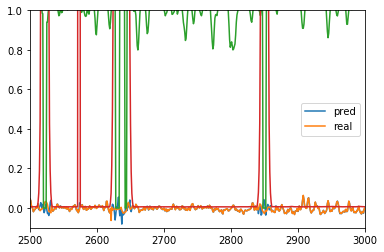

In [402]:
z.plot(28,[2500,3000])
plt.plot(dataset.serialize(28,"aspcap"))
plt.plot(dataset.serialize(28,"aspcap_err"))
plt.ylim(-0.1,1)
#z.plot(30,[4000,4200])

#plt.plot(dataset.z)

In [15]:
w = vector.LinearTransformation(z_cut_train,y_train)
nonlinear_w = vector.NonLinearTransformation(z_cut_train,y_train)
nonlinear_w.fit(n_epochs=500)

err:0.04488150775432587
err:0.046702321618795395
err:0.04821041598916054
err:0.04785271733999252
err:0.04324565455317497
err:0.045362893491983414
err:0.03744218125939369
err:0.038325246423482895
err:0.03813396021723747
err:0.03799916431307793
err:0.03453987464308739
err:0.03550704941153526
err:0.03146910294890404
err:0.02745293825864792
err:0.04105328023433685
err:0.03154441714286804
err:0.025889096781611443
err:0.02714667096734047
err:0.02160009741783142
err:0.02436966635286808
err:0.025059355422854424
err:0.024019593372941017
err:0.02557854726910591
err:0.02281409688293934
err:0.024251848459243774
err:0.02481776289641857
err:0.022554008290171623
err:0.020528053864836693
err:0.024982929229736328
err:0.02488124929368496
err:0.02906549908220768
err:0.03400775045156479
err:0.042707353830337524
err:0.030987154692411423
err:0.025631312280893326
err:0.022945448756217957
err:0.02829221822321415
err:0.022267082706093788
err:0.02121553011238575
err:0.01960087940096855
err:0.022609297186136246


err:0.011497058905661106
err:0.010381747968494892
err:0.010805793106555939
err:0.009137853980064392
err:0.010303053073585033
err:0.011007617227733135
err:0.011058174073696136
err:0.011482032015919685
err:0.01128697395324707
err:0.011771857738494873
err:0.009672603569924831
err:0.013612196780741215
err:0.010048684664070606
err:0.008859501220285892
err:0.00891577173024416
err:0.007853452116250992
err:0.008358380757272243
err:0.008263885043561459
err:0.00874266680330038
err:0.010418522171676159
err:0.0091415299102664
err:0.00838945060968399
err:0.008846363052725792
err:0.008539080619812012
err:0.008067174814641476
err:0.010914511047303677
err:0.009493626654148102
err:0.012455104850232601
err:0.0124947689473629
err:0.018748311325907707
err:0.014200806617736816
err:0.01194029487669468
err:0.00953206978738308
err:0.013517032377421856
err:0.010669813491404057
err:0.009823158383369446
err:0.009301535785198212
err:0.0104669239372015
err:0.010767010971903801
err:0.011521980166435242
err:0.008449

err:0.010966657660901546
err:0.009803831577301025
err:0.01013462245464325
err:0.008588838391005993
err:0.009932558052241802
err:0.010435402393341064
err:0.010677668265998363
err:0.011047601699829102
err:0.010765676386654377
err:0.01130699273198843
err:0.009139696136116982
err:0.012951049022376537
err:0.009587903507053852
err:0.00848228856921196
err:0.008396348915994167
err:0.0075094872154295444
err:0.007996859028935432
err:0.007861411198973656
err:0.00836181640625
err:0.009968514554202557
err:0.008616127073764801
err:0.00789379607886076
err:0.008352354168891907
err:0.00816262885928154
err:0.007719318848103285
err:0.010384690016508102
err:0.009022432379424572
err:0.011695471592247486
err:0.011700872331857681
err:0.017457975074648857
err:0.01344884280115366
err:0.011339105665683746
err:0.009163480252027512
err:0.01260076742619276
err:0.01012424286454916
err:0.009381194598972797
err:0.009025386534631252
err:0.009892058558762074
err:0.010052933357656002
err:0.011003333143889904
err:0.00805

err:0.008188817650079727
err:0.009681297466158867
err:0.010000932030379772
err:0.010380224324762821
err:0.01069368701428175
err:0.010342467576265335
err:0.010929422453045845
err:0.008730455301702023
err:0.012488259933888912
err:0.00924998614937067
err:0.008206003345549107
err:0.008005637675523758
err:0.007234740536659956
err:0.007743407040834427
err:0.007540811784565449
err:0.008065367117524147
err:0.009633250534534454
err:0.008214202709496021
err:0.007525239605456591
err:0.007976376451551914
err:0.007854526862502098
err:0.007447550538927317
err:0.009961528703570366
err:0.008607008494436741
err:0.011098128743469715
err:0.0110584432259202
err:0.016564812511205673
err:0.012899630703032017
err:0.010827937163412571
err:0.008884282782673836
err:0.011945766396820545
err:0.009643088094890118
err:0.009027664549648762
err:0.008775546215474606
err:0.009420862421393394
err:0.009489988908171654
err:0.010619648732244968
err:0.007693126332014799
err:0.009570278227329254
err:0.010525538586080074
err:

err:0.007849512621760368
err:0.009462629444897175
err:0.009619798511266708
err:0.01009643916040659
err:0.010376066900789738
err:0.009951959364116192
err:0.010572537779808044
err:0.008366573601961136
err:0.012121964246034622
err:0.008963572792708874
err:0.007952751591801643
err:0.007674487307667732
err:0.006999957840889692
err:0.007519166450947523
err:0.007252531126141548
err:0.007800137158483267
err:0.009343145415186882
err:0.007875557988882065
err:0.007208601105958223
err:0.0076623642817139626
err:0.0075903586111962795
err:0.007180896122008562
err:0.009582490660250187
err:0.00823685061186552
err:0.010560465976595879
err:0.010484925471246243
err:0.015798190608620644
err:0.012393658980727196
err:0.0103747034445405
err:0.008628778159618378
err:0.011415231972932816
err:0.00921360682696104
err:0.008718117140233517
err:0.008522291667759418
err:0.008980832993984222
err:0.00901697389781475
err:0.010264212265610695
err:0.007339724339544773
err:0.009111984632909298
err:0.010060691274702549
err:

err:0.009259737096726894
err:0.009276965633034706
err:0.009812573902308941
err:0.010081390850245953
err:0.009592946618795395
err:0.010242072865366936
err:0.008044684305787086
err:0.011817416176199913
err:0.008725334890186787
err:0.007731297984719276
err:0.007406287826597691
err:0.006787077523767948
err:0.007311967667192221
err:0.0069850473664700985
err:0.007549523375928402
err:0.009096600115299225
err:0.007577722426503897
err:0.006939394399523735
err:0.007399441208690405
err:0.00734099093824625
err:0.006935963407158852
err:0.009219372645020485
err:0.007888119667768478
err:0.010084189474582672
err:0.009978249669075012
err:0.015107923187315464
err:0.01194310374557972
err:0.009984753094613552
err:0.008411429822444916
err:0.010969970375299454
err:0.008842936716973782
err:0.008440655656158924
err:0.008268500678241253
err:0.00859621912240982
err:0.008600025437772274
err:0.00994265265762806
err:0.007000559475272894
err:0.008692332543432713
err:0.009640322998166084
err:0.008270555175840855
err

err:0.0073471334762871265
err:0.009070323780179024
err:0.008975802920758724
err:0.009553404524922371
err:0.009797273203730583
err:0.0092825498431921
err:0.009939196519553661
err:0.007764101028442383
err:0.011545727029442787
err:0.008511370047926903
err:0.0075326175428926945
err:0.007182584144175053
err:0.00659953523427248
err:0.007118582725524902
err:0.006745938677340746
err:0.0073256175965070724
err:0.008875553496181965
err:0.007334189955145121
err:0.0067132823169231415
err:0.007172809913754463
err:0.007104130461812019
err:0.006694918032735586
err:0.00887391995638609
err:0.007561885751783848
err:0.009657483547925949
err:0.00954456441104412
err:0.014495999552309513
err:0.011544247157871723
err:0.009622421115636826
err:0.008214685134589672
err:0.010568520985543728
err:0.008535015396773815
err:0.00819934718310833
err:0.00801441166549921
err:0.008276458829641342
err:0.008233626373112202
err:0.009641362354159355
err:0.006693142931908369
err:0.008314467035233974
err:0.009270728565752506
err

err:0.008899793960154057
err:0.00871787779033184
err:0.009327176958322525
err:0.009528525173664093
err:0.009006313048303127
err:0.009673926047980785
err:0.007537699304521084
err:0.011306000873446465
err:0.008333680219948292
err:0.007361005991697311
err:0.00699772359803319
err:0.006433931179344654
err:0.0069482517428696156
err:0.006527389399707317
err:0.007135150954127312
err:0.008688099682331085
err:0.0071280598640441895
err:0.006532131228595972
err:0.006983952596783638
err:0.006907630246132612
err:0.006464117672294378
err:0.008568261750042439
err:0.007285540923476219
err:0.009307187981903553
err:0.009202499873936176
err:0.013986611738801003
err:0.011181419715285301
err:0.009295562282204628
err:0.00804052222520113
err:0.01020593661814928
err:0.008283878676593304
err:0.007998782210052013
err:0.007795520126819611
err:0.008005344308912754
err:0.007935377769172192
err:0.009372239001095295
err:0.006436684634536505
err:0.008009232580661774
err:0.008945651352405548
err:0.007767179049551487
er

err:0.00874557625502348
err:0.008503591641783714
err:0.009137026034295559
err:0.009284823201596737
err:0.008768778294324875
err:0.009452145546674728
err:0.0073588015511631966
err:0.011088814586400986
err:0.008180899545550346
err:0.007196690887212753
err:0.006841289810836315
err:0.006288184784352779
err:0.0068041919730603695
err:0.006332188379019499
err:0.006974098272621632
err:0.008523638360202312
err:0.006950384937226772
err:0.006381398066878319
err:0.006828052923083305
err:0.006747441366314888
err:0.0062520322389900684
err:0.00830119475722313
err:0.007059271447360516
err:0.009025909006595612
err:0.008924931287765503
err:0.01353368815034628
err:0.010851562954485416
err:0.009003677405416965
err:0.00788993202149868
err:0.009898912161588669
err:0.00807028729468584
err:0.007831228896975517
err:0.007599500007927418
err:0.007758669089525938
err:0.007682697847485542
err:0.00913201179355383
err:0.006230778526514769
err:0.00776246702298522
err:0.008671628311276436
err:0.007601350545883179
err:

err:0.00897609069943428
err:0.009072582237422466
err:0.008565935306251049
err:0.009263080544769764
err:0.007212687749415636
err:0.010879440233111382
err:0.008040353655815125
err:0.007034314796328545
err:0.006705753970891237
err:0.0061659784987568855
err:0.006684251595288515
err:0.006163289304822683
err:0.006840869784355164
err:0.008372059091925621
err:0.006793829146772623
err:0.006253756117075682
err:0.0066938516683876514
err:0.006616602186113596
err:0.006065254099667072
err:0.008074567653238773
err:0.006879049353301525
err:0.008798002265393734
err:0.008694598451256752
err:0.013120598159730434
err:0.010561907663941383
err:0.00874402467161417
err:0.007759363856166601
err:0.009635930880904198
err:0.007887104526162148
err:0.007687854114919901
err:0.007423454895615578
err:0.007541642989963293
err:0.007470429874956608
err:0.008929029107093811
err:0.006059898994863033
err:0.007557506673038006
err:0.008434656076133251
err:0.0074635702185332775
err:0.007474250625818968
err:0.008162358775734901

err:0.009105316363275051
err:0.007091139443218708
err:0.01066723931580782
err:0.007908984087407589
err:0.0068814693950116634
err:0.006590469274669886
err:0.0060630370862782
err:0.006589914672076702
err:0.006020871456712484
err:0.006724681239575148
err:0.008231081999838352
err:0.006654507014900446
err:0.006148771848529577
err:0.006578827742487192
err:0.0065108840353786945
err:0.005902731791138649
err:0.007883415557444096
err:0.00673219608142972
err:0.008600648492574692
err:0.008502727374434471
err:0.012747853994369507
err:0.01030524168163538
err:0.008519100956618786
err:0.007643836550414562
err:0.009409679099917412
err:0.007724359631538391
err:0.007559619843959808
err:0.007269273512065411
err:0.007345865946263075
err:0.007289332337677479
err:0.008762375451624393
err:0.005928247235715389
err:0.007392452098429203
err:0.008230594918131828
err:0.0073514673858881
err:0.007296908181160688
err:0.007991456426680088
err:0.00967990793287754
err:0.00718956021592021
err:0.0059133791364729404
err:0.

err:0.006985484156757593
err:0.010455215349793434
err:0.007780464366078377
err:0.006733849178999662
err:0.006494305096566677
err:0.005981589667499065
err:0.006511768326163292
err:0.005899218376725912
err:0.006619915831834078
err:0.008096507750451565
err:0.0065356711857020855
err:0.006064784247428179
err:0.006478938739746809
err:0.006426864303648472
err:0.005762521643191576
err:0.007707508280873299
err:0.006611072923988104
err:0.008427368476986885
err:0.008334793150424957
err:0.012420428916811943
err:0.010080195963382721
err:0.008322520181536674
err:0.00753815658390522
err:0.00921463593840599
err:0.007577094715088606
err:0.007442607078701258
err:0.007125763688236475
err:0.007164032198488712
err:0.007134466897696257
err:0.008621725253760815
err:0.00582575099542737
err:0.007249835412949324
err:0.008051056414842606
err:0.007254166528582573
err:0.00714011350646615
err:0.007841677404940128
err:0.00948715303093195
err:0.007042603567242622
err:0.0058206296525895596
err:0.006642789114266634
err

err:0.006892021745443344
err:0.010246314108371735
err:0.007658075541257858
err:0.006597808562219143
err:0.006413730327039957
err:0.005916852969676256
err:0.006449627224355936
err:0.005795612931251526
err:0.006530712824314833
err:0.007967980578541756
err:0.006431066431105137
err:0.005997604224830866
err:0.006393844727426767
err:0.006356807891279459
err:0.005639513023197651
err:0.007557578384876251
err:0.006507727783173323
err:0.008277595043182373
err:0.00819353386759758
err:0.012131608091294765
err:0.009883749298751354
err:0.008151405490934849
err:0.007442759815603495
err:0.009047135710716248
err:0.0074445330537855625
err:0.007332014851272106
err:0.006995702628046274
err:0.007002184167504311
err:0.007002434693276882
err:0.008503705263137817
err:0.005744566209614277
err:0.007132278755307198
err:0.007897167466580868
err:0.007171220611780882
err:0.007007204927504063
err:0.007710167206823826
err:0.0093081621453166
err:0.006912308279424906
err:0.005743137560784817
err:0.006547752767801285
er

err:0.007537935860455036
err:0.006470343563705683
err:0.006342122796922922
err:0.005859937984496355
err:0.006397280376404524
err:0.005704397801309824
err:0.006450076587498188
err:0.007850553840398788
err:0.0063410233706235886
err:0.005944236181676388
err:0.006318784784525633
err:0.006300446577370167
err:0.00553534273058176
err:0.007430138532072306
err:0.006421383935958147
err:0.008143297396600246
err:0.00806973036378622
err:0.011874084360897541
err:0.009702768176794052
err:0.00799837801605463
err:0.007359471172094345
err:0.008899006061255932
err:0.007325725629925728
err:0.0072312671691179276
err:0.006879718508571386
err:0.006855139043182135
err:0.006888555828481913
err:0.008409366011619568
err:0.005681858863681555
err:0.007036103401333094
err:0.007766543887555599
err:0.007097373250871897
err:0.006894796155393124
err:0.007593135815113783
err:0.009151067584753036
err:0.006798568647354841
err:0.0056779212318360806
err:0.006465395446866751
err:0.008019786328077316
err:0.007198984269052744


err:0.007427560165524483
err:0.006353816483169794
err:0.006285844836384058
err:0.005805280525237322
err:0.006352899130433798
err:0.005623728968203068
err:0.006376753095537424
err:0.007739595137536526
err:0.006266051437705755
err:0.0059021636843681335
err:0.006254199892282486
err:0.006251780781894922
err:0.005445500370115042
err:0.007313694804906845
err:0.006344553083181381
err:0.008022764697670937
err:0.007963215000927448
err:0.01164999883621931
err:0.009539793245494366
err:0.00786970928311348
err:0.007285150699317455
err:0.008763369172811508
err:0.00721777742728591
err:0.007143403869122267
err:0.0067746760323643684
err:0.006717904936522245
err:0.006786039099097252
err:0.008330395445227623
err:0.0056332796812057495
err:0.006949243601411581
err:0.007651298772543669
err:0.007029572036117315
err:0.0067944955080747604
err:0.0074919709004461765
err:0.009005168452858925
err:0.00670084822922945
err:0.005614715162664652
err:0.006394519936293364
err:0.007904049940407276
err:0.007120885886251926

err:0.006250682286918163
err:0.006236545741558075
err:0.005758911836892366
err:0.0063143568113446236
err:0.005551015492528677
err:0.006313226651400328
err:0.007635440677404404
err:0.006199589464813471
err:0.005866973195225
err:0.006200212519615889
err:0.006209551822394133
err:0.005362651776522398
err:0.007208830211311579
err:0.006275419611483812
err:0.007914579473435879
err:0.007870418950915337
err:0.011449038982391357
err:0.0093935402110219
err:0.0077547356486320496
err:0.0072155422531068325
err:0.008641843684017658
err:0.007116828579455614
err:0.007060775998979807
err:0.006679070647805929
err:0.006597254890948534
err:0.00669869827106595
err:0.0082620307803154
err:0.005592911969870329
err:0.006879822351038456
err:0.007547196466475725
err:0.006972638890147209
err:0.006704872939735651
err:0.007404346950352192
err:0.008875095285475254
err:0.006612580735236406
err:0.005555256269872189
err:0.006329554133117199
err:0.007799854036420584
err:0.0070479512214660645
err:0.00722412159666419
err:0

err:0.0062780496664345264
err:0.00548535818234086
err:0.0062565249390900135
err:0.007541842292994261
err:0.006144833751022816
err:0.005834287963807583
err:0.006149498280137777
err:0.006169652100652456
err:0.005287347361445427
err:0.007114564534276724
err:0.006210192572325468
err:0.007820776663720608
err:0.007786187343299389
err:0.011271192692220211
err:0.009264647960662842
err:0.007649978622794151
err:0.007151705212891102
err:0.00852974783629179
err:0.007026330102235079
err:0.006985895801335573
err:0.006591616664081812
err:0.006491664797067642
err:0.0066198185086250305
err:0.00820727739483118
err:0.005557234864681959
err:0.006818060297518969
err:0.007455367129296064
err:0.006922988686710596
err:0.006622792687267065
err:0.007326358463615179
err:0.008756632916629314
err:0.006536175962537527
err:0.005503160413354635
err:0.006267125718295574
err:0.007703868206590414
err:0.006979010533541441
err:0.007131554186344147
err:0.006112557370215654
err:0.007871744222939014
err:0.007572240196168423


err:0.0062060304917395115
err:0.007452103309333324
err:0.0060975211672484875
err:0.005805377848446369
err:0.006101394072175026
err:0.006131039932370186
err:0.005220409017056227
err:0.007033448200672865
err:0.006150142289698124
err:0.007738816551864147
err:0.007710008881986141
err:0.011113427579402924
err:0.009144816547632217
err:0.00755517091602087
err:0.0070932102389633656
err:0.008433276787400246
err:0.006944037042558193
err:0.0069164372980594635
err:0.006509009748697281
err:0.006395886652171612
err:0.006547241471707821
err:0.00815904513001442
err:0.005525364074856043
err:0.0067618899047374725
err:0.007372450083494186
err:0.006872984115034342
err:0.006545349955558777
err:0.0072545139119029045
err:0.008647081442177296
err:0.006468724459409714
err:0.005454373545944691
err:0.006207468919456005
err:0.007616780698299408
err:0.006917211227118969
err:0.007047041319310665
err:0.006042133551090956
err:0.007808613125234842
err:0.007513896562159061
err:0.00818304717540741
err:0.0079830121248960

err:0.006058664992451668
err:0.005778517574071884
err:0.006056706886738539
err:0.006095402874052525
err:0.005165413022041321
err:0.0069611044600605965
err:0.006095021963119507
err:0.00766322435811162
err:0.007642042823135853
err:0.010965755209326744
err:0.009034603834152222
err:0.007466279435902834
err:0.007042787969112396
err:0.008344071917235851
err:0.00687290308997035
err:0.006852698978036642
err:0.006435391027480364
err:0.0063123940490186214
err:0.0064815436489880085
err:0.008114635944366455
err:0.005498751066625118
err:0.006710651330649853
err:0.007297676056623459
err:0.0068242973648011684
err:0.006479411385953426
err:0.0071857948787510395
err:0.008550971746444702
err:0.006408648565411568
err:0.0054079885594546795
err:0.006152852904051542
err:0.007535964250564575
err:0.0068598538637161255
err:0.00696862768381834
err:0.005974965635687113
err:0.007750399876385927
err:0.007455415558069944
err:0.008109663613140583
err:0.007889488711953163
err:0.007442222908139229
err:0.008264250122010

err:0.006015098188072443
err:0.006061282474547625
err:0.005115427076816559
err:0.0068922038190066814
err:0.00604282645508647
err:0.00759656960144639
err:0.00758094247430563
err:0.010827761143445969
err:0.008931866846978664
err:0.007386400830000639
err:0.006996460724622011
err:0.008261139504611492
err:0.006808703765273094
err:0.006792226806282997
err:0.0063684494234621525
err:0.006233619526028633
err:0.00642071757465601
err:0.008076847530901432
err:0.005475944839417934
err:0.006664268206804991
err:0.007227556314319372
err:0.0067803882993757725
err:0.006417139433324337
err:0.007121853530406952
err:0.008462256751954556
err:0.006356220226734877
err:0.005365457851439714
err:0.00610192958265543
err:0.007465707138180733
err:0.006807563826441765
err:0.006896793842315674
err:0.00591002032160759
err:0.0076943994499742985
err:0.0074015031568706036
err:0.008041697554290295
err:0.007802055217325687
err:0.007364434190094471
err:0.00818641483783722
err:0.006408435292541981
err:0.008948025293648243
er

err:0.005068819038569927
err:0.006827539298683405
err:0.00599320326000452
err:0.007537181954830885
err:0.007525339722633362
err:0.010699971579015255
err:0.00883412454277277
err:0.0073166596703231335
err:0.006950171664357185
err:0.008184409700334072
err:0.006750386208295822
err:0.006738056428730488
err:0.0063086035661399364
err:0.006162064149975777
err:0.006367010995745659
err:0.008040407672524452
err:0.0054565975442528725
err:0.006615574471652508
err:0.007165176793932915
err:0.006737992633134127
err:0.006362875923514366
err:0.007058561779558659
err:0.00837661698460579
err:0.006309525575488806
err:0.005324958823621273
err:0.006054779514670372
err:0.00739858765155077
err:0.006759699434041977
err:0.006828402169048786
err:0.005846194922924042
err:0.00764106959104538
err:0.007352988701313734
err:0.007980210706591606
err:0.00772304879501462
err:0.007292225956916809
err:0.00811473373323679
err:0.006356400437653065
err:0.008804192766547203
err:0.006876762956380844
err:0.005828935652971268
err:

err:0.006769910920411348
err:0.0059469956904649734
err:0.007483688648790121
err:0.007477802690118551
err:0.010579538531601429
err:0.008737796917557716
err:0.007254032418131828
err:0.006908057723194361
err:0.008113237097859383
err:0.006695945747196674
err:0.006688515190035105
err:0.006250690668821335
err:0.00609458377584815
err:0.006316621787846088
err:0.008004887960851192
err:0.005440221633762121
err:0.006569438613951206
err:0.0071087912656366825
err:0.006693812552839518
err:0.0063116890378296375
err:0.006998136173933744
err:0.008297628723084927
err:0.006262584123760462
err:0.005285126157104969
err:0.006011625286191702
err:0.0073354546912014484
err:0.006713159382343292
err:0.006764039397239685
err:0.005787989590317011
err:0.007587399799376726
err:0.007309638429433107
err:0.007919596508145332
err:0.007648258935660124
err:0.007224014960229397
err:0.008048026822507381
err:0.006306493189185858
err:0.008669189177453518
err:0.006806137505918741
err:0.005765154957771301
err:0.0060056685470044

err:0.0067148879170417786
err:0.005903358105570078
err:0.007432000245898962
err:0.007434140890836716
err:0.010465149767696857
err:0.00864415243268013
err:0.00719328410923481
err:0.006868918891996145
err:0.008046709932386875
err:0.006646476220339537
err:0.006642731372267008
err:0.00619783578440547
err:0.00603055115789175
err:0.006267725024372339
err:0.007971502840518951
err:0.005422310903668404
err:0.006528324447572231
err:0.007052580825984478
err:0.006650661583989859
err:0.006264975294470787
err:0.006939719431102276
err:0.008223557844758034
err:0.006221346091479063
err:0.005246638786047697
err:0.005970811937004328
err:0.007274822797626257
err:0.006670718546956778
err:0.006703582126647234
err:0.005730218254029751
err:0.0075376699678599834
err:0.007268924731761217
err:0.007860206998884678
err:0.007577891927212477
err:0.007160889450460672
err:0.007985029369592667
err:0.006259112153202295
err:0.00853969156742096
err:0.00673834839835763
err:0.005705306772142649
err:0.005975634790956974
err:

err:0.005860485602170229
err:0.007381911389529705
err:0.007394278887659311
err:0.010358836501836777
err:0.008553262799978256
err:0.0071351476944983006
err:0.006831709761172533
err:0.00798289105296135
err:0.006598624866455793
err:0.0065999398939311504
err:0.006146052852272987
err:0.005968404468148947
err:0.006222586613148451
err:0.007939011789858341
err:0.0054054842330515385
err:0.006489132065325975
err:0.00700048403814435
err:0.006607343442738056
err:0.0062225027941167355
err:0.00688624382019043
err:0.008151744492352009
err:0.006182635203003883
err:0.005211744457483292
err:0.005932873114943504
err:0.007217514794319868
err:0.006628519389778376
err:0.006647423841059208
err:0.005675442051142454
err:0.007491501979529858
err:0.007230337709188461
err:0.007807233836501837
err:0.0075093479827046394
err:0.007097190245985985
err:0.00792453158646822
err:0.0062113115563988686
err:0.008420116268098354
err:0.006674241740256548
err:0.005646322853863239
err:0.0059476871974766254
err:0.0054927133023738

err:0.005820013117045164
err:0.0073318216018378735
err:0.007354147732257843
err:0.010263217613101006
err:0.00846865028142929
err:0.007083769887685776
err:0.006796207744628191
err:0.007922707125544548
err:0.006556568667292595
err:0.006562326569110155
err:0.006098551210016012
err:0.005913579370826483
err:0.006180137395858765
err:0.00790922250598669
err:0.0053900666534900665
err:0.006456393748521805
err:0.006951140705496073
err:0.006565645802766085
err:0.006183375604450703
err:0.006835523527115583
err:0.00808762852102518
err:0.006144359242171049
err:0.005176646169275045
err:0.0058951545506715775
err:0.007163133937865496
err:0.0065873838029801846
err:0.006596850231289864
err:0.00562323397025466
err:0.007448024116456509
err:0.007193705998361111
err:0.0077574304305016994
err:0.007443356793373823
err:0.00703791156411171
err:0.007871118374168873
err:0.006164599675685167
err:0.008309870027005672
err:0.006614050827920437
err:0.0055932109244167805
err:0.005921812262386084
err:0.005466340575367212

err:0.00605349987745285
err:0.005068251863121986
err:0.005930989980697632
err:0.006915464531630278
err:0.0058844140730798244
err:0.005626795347779989
err:0.005807659588754177
err:0.005866637919098139
err:0.004885506350547075
err:0.0065651386976242065
err:0.005780251696705818
err:0.007283835206180811
err:0.007317531853914261
err:0.010175216011703014
err:0.008388390764594078
err:0.007032256573438644
err:0.0067625525407493114
err:0.0078662084415555
err:0.006515085231512785
err:0.006524995435029268
err:0.0060518477112054825
err:0.0058617726899683475
err:0.006140079814940691
err:0.007882130332291126
err:0.005377064924687147
err:0.006425135303288698
err:0.006902293302118778
err:0.006524097174406052
err:0.006146291736513376
err:0.006789827719330788
err:0.008022819645702839
err:0.006107026245445013
err:0.00514238141477108
err:0.0058579351752996445
err:0.007113840896636248
err:0.0065484242513775826
err:0.006549254525452852
err:0.005574497394263744
err:0.007406338583678007
err:0.0071588191203773

err:0.005907006096094847
err:0.006861721631139517
err:0.005865208804607391
err:0.00560792488977313
err:0.0057801855728030205
err:0.005836643278598785
err:0.004855070263147354
err:0.006519733462482691
err:0.005743374582380056
err:0.007237034384161234
err:0.007279403042048216
err:0.010088320821523666
err:0.00831015408039093
err:0.006983286235481501
err:0.00672884238883853
err:0.007808402646332979
err:0.006479210685938597
err:0.006490107625722885
err:0.0060072471387684345
err:0.005815162789076567
err:0.0061005158349871635
err:0.007855275645852089
err:0.005362862255424261
err:0.006395392585545778
err:0.006856952328234911
err:0.006483518052846193
err:0.006111567839980125
err:0.006746858358383179
err:0.007963108830153942
err:0.0060729701071977615
err:0.00510826800018549
err:0.005822193808853626
err:0.007064260076731443
err:0.006512284278869629
err:0.006502095144242048
err:0.005528389010578394
err:0.00736611895263195
err:0.0071235583163797855
err:0.007668872829526663
err:0.00731528177857399
e

err:0.005882590543478727
err:0.006811058614403009
err:0.005845710169523954
err:0.005589325446635485
err:0.005753418896347284
err:0.005807639565318823
err:0.004824769217520952
err:0.006476997397840023
err:0.005707597825676203
err:0.007193910423666239
err:0.00724200950935483
err:0.010002391412854195
err:0.008233827538788319
err:0.006932499818503857
err:0.006696105934679508
err:0.007751924451440573
err:0.006440683268010616
err:0.006456906441599131
err:0.00596592528745532
err:0.005771116819232702
err:0.0060621281154453754
err:0.007828973233699799
err:0.005347798112779856
err:0.006366734392940998
err:0.006810759659856558
err:0.006442713085561991
err:0.006078930106014013
err:0.006705998908728361
err:0.007906126789748669
err:0.006038075312972069
err:0.005074354819953442
err:0.00578891159966588
err:0.007018062751740217
err:0.006477236747741699
err:0.006455683149397373
err:0.005485291592776775
err:0.007329337764531374
err:0.007091096136718988
err:0.007628724444657564
err:0.007255083881318569
er

err:0.006764098070561886
err:0.005825289990752935
err:0.005570306908339262
err:0.005725597497075796
err:0.005778856109827757
err:0.004793155938386917
err:0.0064356098882853985
err:0.005672608967870474
err:0.007152006961405277
err:0.007206268608570099
err:0.00991871114820242
err:0.008161534555256367
err:0.006884162314236164
err:0.0066634733229875565
err:0.007702167611569166
err:0.0064054448157548904
err:0.006427185144275427
err:0.0059249806217849255
err:0.005728738382458687
err:0.006024495232850313
err:0.0078038605861365795
err:0.005335058551281691
err:0.006339285522699356
err:0.00676718819886446
err:0.006401645019650459
err:0.006046947091817856
err:0.006664922460913658
err:0.007853575050830841
err:0.006003407761454582
err:0.0050421361811459064
err:0.005754320416599512
err:0.0069738514721393585
err:0.006442975252866745
err:0.006413165479898453
err:0.00544372433796525
err:0.007294313050806522
err:0.007060028612613678
err:0.0075896866619586945
err:0.007196391467005014
err:0.00682995142415

err:0.005806539673358202
err:0.005552022252231836
err:0.005698035005480051
err:0.0057529788464307785
err:0.004763924051076174
err:0.006397617515176535
err:0.005639687180519104
err:0.007111431565135717
err:0.007172638084739447
err:0.009837946854531765
err:0.008091547526419163
err:0.006838160566985607
err:0.006631629075855017
err:0.007655743509531021
err:0.006371064577251673
err:0.0064009735360741615
err:0.005887688137590885
err:0.005690001882612705
err:0.005991471465677023
err:0.007782812230288982
err:0.005324430763721466
err:0.0063120401464402676
err:0.006724043749272823
err:0.006361909676343203
err:0.00601494824513793
err:0.006625957787036896
err:0.00780633557587862
err:0.005969669204205275
err:0.005013050977140665
err:0.005721773486584425
err:0.0069300164468586445
err:0.00640867417678237
err:0.006373556796461344
err:0.005403976421803236
err:0.0072602564468979836
err:0.007027267478406429
err:0.007551685906946659
err:0.007140753790736198
err:0.006783192045986652
err:0.00763436919078230

err:0.005788798909634352
err:0.00553306145593524
err:0.005672103725373745
err:0.005727528594434261
err:0.004738845396786928
err:0.006361260544508696
err:0.005611324682831764
err:0.007073769345879555
err:0.007139358203858137
err:0.009760808199644089
err:0.008024868555366993
err:0.0067918444983661175
err:0.006601119413971901
err:0.007610101252794266
err:0.006340139079838991
err:0.006372166331857443
err:0.005850639194250107
err:0.005656426306813955
err:0.005961452145129442
err:0.00775945046916604
err:0.00531197153031826
err:0.00628419267013669
err:0.006685289088636637
err:0.006320291664451361
err:0.005984568037092686
err:0.006592193152755499
err:0.007758249528706074
err:0.005940183065831661
err:0.00498572364449501
err:0.005689180921763182
err:0.006886433809995651
err:0.006377124693244696
err:0.00633693253621459
err:0.005366360303014517
err:0.007228120695799589
err:0.006992356386035681
err:0.007516032084822655
err:0.007085397839546204
err:0.00673858355730772
err:0.0075952475890517235
err:0

err:0.00663211802020669
err:0.005771738942712545
err:0.005513423588126898
err:0.0056465682573616505
err:0.0057022240944206715
err:0.004714570008218288
err:0.006324575748294592
err:0.005582976620644331
err:0.007039815653115511
err:0.007108538411557674
err:0.009688196703791618
err:0.007959381677210331
err:0.006747888866811991
err:0.006570836529135704
err:0.007569853216409683
err:0.006312740501016378
err:0.006345715373754501
err:0.005815465003252029
err:0.005623332224786282
err:0.00593241723254323
err:0.0077385311014950275
err:0.005298338830471039
err:0.0062583982944488525
err:0.006647446658462286
err:0.006282075308263302
err:0.005957231856882572
err:0.006557148415595293
err:0.007714971899986267
err:0.005909909959882498
err:0.004958851262927055
err:0.005658435169607401
err:0.006846500560641289
err:0.006345917470753193
err:0.006304378621280193
err:0.005331436637789011
err:0.007195476442575455
err:0.006960305385291576
err:0.007481750566512346
err:0.0070335171185433865
err:0.0066955541260540

err:0.005752564407885075
err:0.005496000871062279
err:0.005623233504593372
err:0.005679947789758444
err:0.004692611750215292
err:0.0062889582477509975
err:0.005556284915655851
err:0.007007918786257505
err:0.007081103976815939
err:0.009617933072149754
err:0.007894249632954597
err:0.006706854794174433
err:0.006541337352246046
err:0.007530114147812128
err:0.0062851812690496445
err:0.006321044638752937
err:0.00578460143879056
err:0.005594591610133648
err:0.005906013306230307
err:0.007716641761362553
err:0.005283370614051819
err:0.0062325564213097095
err:0.006613552570343018
err:0.0062440321780741215
err:0.005928384605795145
err:0.006526044569909573
err:0.0076712965965271
err:0.005882578901946545
err:0.004933231044560671
err:0.005629085004329681
err:0.006808785255998373
err:0.006314215715974569
err:0.006270838901400566
err:0.0052986484952270985
err:0.007163861766457558
err:0.006927280221134424
err:0.007446832489222288
err:0.006983103230595589
err:0.0066523440182209015
err:0.0075200861319899

err:0.005479610059410334
err:0.005601716227829456
err:0.005658230744302273
err:0.004671306814998388
err:0.006255169864743948
err:0.005529684480279684
err:0.0069768126122653484
err:0.007053453009575605
err:0.009548039175570011
err:0.007831251248717308
err:0.006667295936495066
err:0.006515725515782833
err:0.007491730153560638
err:0.0062609268352389336
err:0.006299279630184174
err:0.005755133926868439
err:0.00556555250659585
err:0.005879934877157211
err:0.0076960669830441475
err:0.005269526969641447
err:0.0062093669548630714
err:0.006580796092748642
err:0.006209099665284157
err:0.005903112236410379
err:0.006495185662060976
err:0.0076313987374305725
err:0.005855475552380085
err:0.004908689763396978
err:0.0056005725637078285
err:0.006773532833904028
err:0.006285126321017742
err:0.006239154376089573
err:0.005267694126814604
err:0.007134178187698126
err:0.006894558668136597
err:0.007412182167172432
err:0.006936233025044203
err:0.006610926240682602
err:0.007483378518372774
err:0.00580184208229

err:0.005460947286337614
err:0.005578723736107349
err:0.00563568901270628
err:0.004650290589779615
err:0.006221839226782322
err:0.005504231434315443
err:0.006947003770619631
err:0.007027572486549616
err:0.00948225986212492
err:0.0077696735970675945
err:0.006627607624977827
err:0.006489942315965891
err:0.007453385274857283
err:0.006233914755284786
err:0.006278146058320999
err:0.005726352334022522
err:0.00554109551012516
err:0.005853799171745777
err:0.007674800232052803
err:0.005254750605672598
err:0.006182994693517685
err:0.006548416335135698
err:0.006172198336571455
err:0.0058794100768864155
err:0.006467042490839958
err:0.007592383772134781
err:0.005830017849802971
err:0.004885688424110413
err:0.005573881324380636
err:0.006740181241184473
err:0.006257300265133381
err:0.006207706872373819
err:0.005236043129116297
err:0.007104738149791956
err:0.0068628680892288685
err:0.007378473412245512
err:0.0068905469961464405
err:0.006569557823240757
err:0.007449490483850241
err:0.005768381059169769

err:0.005442880094051361
err:0.005556680727750063
err:0.005612906534224749
err:0.004629580769687891
err:0.006190143059939146
err:0.005478707142174244
err:0.006916457787156105
err:0.007001953665167093
err:0.009415843524038792
err:0.007710796780884266
err:0.006585387978702784
err:0.006466714199632406
err:0.007413799874484539
err:0.00621047941967845
err:0.00625806488096714
err:0.005698819644749165
err:0.005517397541552782
err:0.005830535665154457
err:0.00765641313046217
err:0.005239143967628479
err:0.006160293240100145
err:0.006517565809190273
err:0.006139854434877634
err:0.00585912773385644
err:0.00644033495336771
err:0.007556846830993891
err:0.005804568529129028
err:0.004862378351390362
err:0.005548975896090269
err:0.006709619890898466
err:0.006230441387742758
err:0.006178671959787607
err:0.005204620771110058
err:0.007075679022818804
err:0.006832481361925602
err:0.007348040584474802
err:0.006845405790954828
err:0.00653298432007432
err:0.007417069282382727
err:0.005733873229473829
err:0.

err:0.0064545427449047565
err:0.005674455314874649
err:0.005424408707767725
err:0.005534457508474588
err:0.005592176225036383
err:0.004609738476574421
err:0.006159747950732708
err:0.00545461243018508
err:0.006887075025588274
err:0.00697683310136199
err:0.00935039296746254
err:0.0076555609703063965
err:0.006545206997543573
err:0.006443726364523172
err:0.007378897164016962
err:0.006187128368765116
err:0.00623802375048399
err:0.005670136772096157
err:0.005492678377777338
err:0.005808731075376272
err:0.007635973393917084
err:0.00522609381005168
err:0.006136822514235973
err:0.006489335093647242
err:0.006105328444391489
err:0.005839092656970024
err:0.0064127277582883835
err:0.007520671468228102
err:0.0057815550826489925
err:0.004839589819312096
err:0.005523597355931997
err:0.006678352132439613
err:0.006202876102179289
err:0.006149353925138712
err:0.0051743946969509125
err:0.007048098370432854
err:0.0068008387461304665
err:0.007318628020584583
err:0.006801509764045477
err:0.006498141679912805

err:0.0056676375679671764
err:0.006426598876714706
err:0.005653750151395798
err:0.0054066176526248455
err:0.005512537434697151
err:0.005572146270424128
err:0.004589955788105726
err:0.006129446439445019
err:0.005431429948657751
err:0.006858031265437603
err:0.006952414754778147
err:0.009288881905376911
err:0.007601758930832148
err:0.006503438111394644
err:0.006419912446290255
err:0.0073430659249424934
err:0.00616451445966959
err:0.006217909976840019
err:0.005645090248435736
err:0.0054696593433618546
err:0.005788722075521946
err:0.007617313414812088
err:0.005213250406086445
err:0.006112954113632441
err:0.006458899937570095
err:0.006073557306081057
err:0.0058201574720442295
err:0.006384814158082008
err:0.007486614864319563
err:0.005758893210440874
err:0.004818812012672424
err:0.005499977618455887
err:0.006648745853453875
err:0.006176406983286142
err:0.006122248247265816
err:0.005142132751643658
err:0.007022740785032511
err:0.00676958030089736
err:0.007290881592780352
err:0.0067607001401484

err:0.005632081069052219
err:0.005387200508266687
err:0.0054907286539673805
err:0.005551590118557215
err:0.0045705921947956085
err:0.006098494399338961
err:0.00540904002264142
err:0.006827736739069223
err:0.006925941910594702
err:0.009231544099748135
err:0.007551705464720726
err:0.0064606983214616776
err:0.0063960435800254345
err:0.007309767417609692
err:0.006140599027276039
err:0.006199830211699009
err:0.005623459815979004
err:0.005447651259601116
err:0.005767881870269775
err:0.007600027602165937
err:0.005201066378504038
err:0.006090458016842604
err:0.006431224290281534
err:0.006042126100510359
err:0.005800971761345863
err:0.006356375757604837
err:0.007453765720129013
err:0.005736593622714281
err:0.004796781111508608
err:0.005476779770106077
err:0.006621573120355606
err:0.006151125766336918
err:0.006096961908042431
err:0.005112361162900925
err:0.0069981892593204975
err:0.006739186588674784
err:0.007264250423759222
err:0.00672181835398078
err:0.006434259004890919
err:0.0073223966173827

err:0.005610490217804909
err:0.005369408987462521
err:0.0054701389744877815
err:0.005531128961592913
err:0.004553074948489666
err:0.006072110030800104
err:0.005388702731579542
err:0.006800627335906029
err:0.006898942869156599
err:0.009176508523523808
err:0.007504231762140989
err:0.006418533623218536
err:0.006374563556164503
err:0.00727796321734786
err:0.006118294782936573
err:0.00617926986888051
err:0.005601009353995323
err:0.005424854811280966
err:0.005747969727963209
err:0.007580638397485018
err:0.0051892600022256374
err:0.0060671172104775906
err:0.006405164487659931
err:0.006009392440319061
err:0.005781995598226786
err:0.006327744573354721
err:0.007420633919537067
err:0.005715405568480492
err:0.004776121582835913
err:0.005453925579786301
err:0.00659598084166646
err:0.006126785650849342
err:0.006071755662560463
err:0.005082946270704269
err:0.006974113639444113
err:0.00670818192884326
err:0.007236785721033812
err:0.006682527717202902
err:0.006403036415576935
err:0.007291608490049839
e

err:0.005590228829532862
err:0.005352073814719915
err:0.005449748132377863
err:0.005511641968041658
err:0.004536965396255255
err:0.0060463035479187965
err:0.005367959383875132
err:0.0067737591452896595
err:0.00687265582382679
err:0.009119930677115917
err:0.0074551901780068874
err:0.0063787177205085754
err:0.006352757569402456
err:0.007245645858347416
err:0.006096904166042805
err:0.006160508841276169
err:0.005579752381891012
err:0.0054031116887927055
err:0.005728378891944885
err:0.007563904859125614
err:0.0051773833110928535
err:0.00604462344199419
err:0.006378945894539356
err:0.005979028530418873
err:0.005762107204645872
err:0.0063011618331074715
err:0.007388128433376551
err:0.005693347193300724
err:0.004755449015647173
err:0.005431332625448704
err:0.006570264231413603
err:0.006104194093495607
err:0.006048946175724268
err:0.005055656190961599
err:0.006948891561478376
err:0.006678501144051552
err:0.007210367359220982
err:0.0066459602676332
err:0.006373681128025055
err:0.0072616022080183

err:0.005568536929786205
err:0.005334831308573484
err:0.0054293409921228886
err:0.005494255572557449
err:0.0045212735421955585
err:0.006023862399160862
err:0.005348143167793751
err:0.00674878153949976
err:0.0068471659906208515
err:0.009062103927135468
err:0.007407751400023699
err:0.006340086925774813
err:0.006329826079308987
err:0.0072126747108995914
err:0.00607572915032506
err:0.006141094956547022
err:0.005559311714023352
err:0.005385023541748524
err:0.005708825774490833
err:0.0075463601388037205
err:0.0051637920551002026
err:0.006022941786795855
err:0.00635362695902586
err:0.005946170073002577
err:0.005743186455219984
err:0.006275251042097807
err:0.007356301881372929
err:0.005669731646776199
err:0.004735848866403103
err:0.005409892648458481
err:0.006544099655002356
err:0.006082305684685707
err:0.006024356000125408
err:0.005029045511037111
err:0.006924835499376059
err:0.006649985909461975
err:0.007184755988419056
err:0.006612151395529509
err:0.006345614790916443
err:0.0072325025685131

err:0.005546589847654104
err:0.0053169457241892815
err:0.005407588090747595
err:0.0054762656800448895
err:0.004506544675678015
err:0.006001184694468975
err:0.005329771898686886
err:0.006724524311721325
err:0.0068210698664188385
err:0.00900537334382534
err:0.007361385505646467
err:0.00630144402384758
err:0.006307981908321381
err:0.007182276342064142
err:0.006053704768419266
err:0.0061241639778018
err:0.00553852366283536
err:0.00536775728687644
err:0.005689105950295925
err:0.007530518341809511
err:0.0051521728746593
err:0.006002368871122599
err:0.006330882199108601
err:0.005916649010032415
err:0.005725968163460493
err:0.006248912308365107
err:0.0073274471797049046
err:0.0056456089951097965
err:0.004716397263109684
err:0.0053899954073131084
err:0.006520893424749374
err:0.006060905754566193
err:0.006003394722938538
err:0.0050030057318508625
err:0.006902099121361971
err:0.00662366533651948
err:0.007159007713198662
err:0.006578443106263876
err:0.0063184332102537155
err:0.007204925641417503
e

err:0.005525649059563875
err:0.005299028009176254
err:0.0053839366883039474
err:0.005458267405629158
err:0.004493143875151873
err:0.005977968219667673
err:0.005309495143592358
err:0.006701087579131126
err:0.006794564891606569
err:0.008949323557317257
err:0.007317116018384695
err:0.0062614623457193375
err:0.006287058349698782
err:0.007152826990932226
err:0.006033745594322681
err:0.006104343570768833
err:0.00551855843514204
err:0.005351454950869083
err:0.005671480670571327
err:0.007514772471040487
err:0.005139456130564213
err:0.005980043672025204
err:0.006305154412984848
err:0.005886900704354048
err:0.005709841847419739
err:0.006223964039236307
err:0.007297488860785961
err:0.005623910576105118
err:0.004696985241025686
err:0.005371324252337217
err:0.006496401038020849
err:0.0060395849868655205
err:0.005981346592307091
err:0.00497650820761919
err:0.006878497079014778
err:0.006598763633519411
err:0.007135047577321529
err:0.006544347386807203
err:0.006292443256825209
err:0.007179205305874348

err:0.0052822791039943695
err:0.005363189149647951
err:0.0054426537826657295
err:0.004481522366404533
err:0.005956779234111309
err:0.00529251154512167
err:0.006677686702460051
err:0.006769809406250715
err:0.008894809521734715
err:0.007274530827999115
err:0.006224810611456633
err:0.006264884956181049
err:0.00712217390537262
err:0.0060136145912110806
err:0.006087772082537413
err:0.005498991813510656
err:0.005332782864570618
err:0.0056531550362706184
err:0.0074965995736420155
err:0.005126554053276777
err:0.005958419758826494
err:0.006282073445618153
err:0.005857639480382204
err:0.005691710859537125
err:0.006197735201567411
err:0.007267964072525501
err:0.005603076424449682
err:0.004679100587964058
err:0.005353228654712439
err:0.0064735421910882
err:0.0060196141712367535
err:0.005960605572909117
err:0.004950779024511576
err:0.00685497373342514
err:0.006574966944754124
err:0.007112597115337849
err:0.0065127769485116005
err:0.006265534553676844
err:0.0071529243141412735
err:0.0054774675518274

err:0.004469616338610649
err:0.005934822838753462
err:0.005273859947919846
err:0.006654488388448954
err:0.006745403166860342
err:0.008840455673635006
err:0.007231695577502251
err:0.006188192404806614
err:0.006244787480682135
err:0.0070939683355391026
err:0.005997580010443926
err:0.006070946808904409
err:0.005481503903865814
err:0.005316791124641895
err:0.005638431292027235
err:0.007479653228074312
err:0.005114097148180008
err:0.0059376126155257225
err:0.006259888876229525
err:0.005828057415783405
err:0.005675734486430883
err:0.006172840017825365
err:0.007241574116051197
err:0.005582187790423632
err:0.0046617561019957066
err:0.0053340969607234
err:0.006451694760471582
err:0.005999974440783262
err:0.005940719973295927
err:0.004927884787321091
err:0.006832427810877562
err:0.006548585370182991
err:0.007087979465723038
err:0.006479928269982338
err:0.006239651702344418
err:0.007127771619707346
err:0.005452765617519617
err:0.006964531261473894
err:0.005843572784215212
err:0.004909868817776442

err:0.005253591574728489
err:0.006631831638514996
err:0.006721668876707554
err:0.008788569830358028
err:0.007185758091509342
err:0.006153881549835205
err:0.00622488372027874
err:0.007065982557833195
err:0.005980206187814474
err:0.006054016761481762
err:0.005461773835122585
err:0.0052978238090872765
err:0.005621243733912706
err:0.00746352830901742
err:0.005101426504552364
err:0.005914769135415554
err:0.006236625835299492
err:0.005800195503979921
err:0.005660272669047117
err:0.006146373692899942
err:0.007215845864266157
err:0.005563374143093824
err:0.004646529443562031
err:0.005317441653460264
err:0.006430238019675016
err:0.005979831330478191
err:0.005918733309954405
err:0.004903858061879873
err:0.0068115838803350925
err:0.006524673663079739
err:0.007066074758768082
err:0.006450744345784187
err:0.006214839406311512
err:0.007103110663592815
err:0.005429632030427456
err:0.006924618035554886
err:0.005817322991788387
err:0.004888744093477726
err:0.005398612469434738
err:0.005063062533736229


err:0.006609038915485144
err:0.00669999560341239
err:0.008739388547837734
err:0.007143280003219843
err:0.0061201974749565125
err:0.006205457262694836
err:0.007038288749754429
err:0.005963696166872978
err:0.006036096718162298
err:0.005444664973765612
err:0.005283778067678213
err:0.005605081096291542
err:0.007445999421179295
err:0.005088807083666325
err:0.005894954781979322
err:0.00621767807751894
err:0.005773233715444803
err:0.005646015517413616
err:0.006124645937234163
err:0.0071892463602125645
err:0.005544113926589489
err:0.004630566108971834
err:0.0053009516559541225
err:0.0064108180813491344
err:0.005960860755294561
err:0.0058985427021980286
err:0.004880884196609259
err:0.006789909675717354
err:0.00650000711902976
err:0.007043247111141682
err:0.006421423051506281
err:0.006190929561853409
err:0.007077162619680166
err:0.005405443254858255
err:0.006884576752781868
err:0.005792530253529549
err:0.004868064541369677
err:0.00537998927757144
err:0.005049797706305981
err:0.005730963777750730

err:0.008687629364430904
err:0.007100390270352364
err:0.006086153443902731
err:0.00618710508570075
err:0.007007628679275513
err:0.0059468308463692665
err:0.006019546650350094
err:0.0054267155937850475
err:0.005268484354019165
err:0.0055906628258526325
err:0.007428512442857027
err:0.005074747838079929
err:0.005872265435755253
err:0.0061953309923410416
err:0.005744930822402239
err:0.005628013517707586
err:0.006101353093981743
err:0.007160855922847986
err:0.005527349188923836
err:0.0046138945035636425
err:0.0052843280136585236
err:0.006388681475073099
err:0.005944320000708103
err:0.005880134645849466
err:0.004858541302382946
err:0.00676771579310298
err:0.006476123817265034
err:0.007021100725978613
err:0.0063934726640582085
err:0.006167169194668531
err:0.007053956389427185
err:0.0053827352821826935
err:0.006847018841654062
err:0.005767605733126402
err:0.004846865776926279
err:0.005360215436667204
err:0.00503741018474102
err:0.005719501059502363
err:0.00453687971457839
err:0.005477273371070

err:0.008638404309749603
err:0.007058442570269108
err:0.006050810217857361
err:0.006166963372379541
err:0.006977500393986702
err:0.0059325676411390305
err:0.006004786118865013
err:0.005411010235548019
err:0.005255918484181166
err:0.005575249902904034
err:0.00741324108093977
err:0.005063654854893684
err:0.005852719768881798
err:0.006176321767270565
err:0.005718687549233437
err:0.005613811779767275
err:0.006079625338315964
err:0.0071351658552885056
err:0.005510740447789431
err:0.004597776103764772
err:0.005267932079732418
err:0.006369228474795818
err:0.005926094483584166
err:0.005861325189471245
err:0.004836393520236015
err:0.006744914688169956
err:0.006452199537307024
err:0.007000942248851061
err:0.0063658207654953
err:0.0061441464349627495
err:0.007030189502984285
err:0.005358891095966101
err:0.0068106153048574924
err:0.005743111949414015
err:0.004825945012271404
err:0.005342069547623396
err:0.0050249663181602955
err:0.005708227399736643
err:0.004523461684584618
err:0.00546259200200438

err:0.007015622686594725
err:0.00601773988455534
err:0.006149750668555498
err:0.006950820796191692
err:0.0059170350432395935
err:0.005989607889205217
err:0.005396341439336538
err:0.005242745857685804
err:0.005561040248721838
err:0.007396994158625603
err:0.005051582586020231
err:0.005830713082104921
err:0.006156150717288256
err:0.00569369550794363
err:0.005599903874099255
err:0.006058164406567812
err:0.0071097612380981445
err:0.005493887700140476
err:0.004582985304296017
err:0.005251201801002026
err:0.006348797585815191
err:0.005908037070184946
err:0.0058419047854840755
err:0.004814443178474903
err:0.006724211852997541
err:0.006429303903132677
err:0.006981987040489912
err:0.006339432206004858
err:0.006121547892689705
err:0.007007930893450975
err:0.0053370315581560135
err:0.006774228531867266
err:0.005719071254134178
err:0.004805262200534344
err:0.0053237853571772575
err:0.005012841429561377
err:0.005697402637451887
err:0.0045104562304914
err:0.005449213087558746
err:0.006094799842685461

err:0.0059850807301700115
err:0.006131419446319342
err:0.006923670414835215
err:0.005899363197386265
err:0.005974528379738331
err:0.005380603950470686
err:0.005229304078966379
err:0.005546271800994873
err:0.00737879890948534
err:0.00503955315798521
err:0.005811565555632114
err:0.006137840449810028
err:0.0056668673641979694
err:0.005587021354585886
err:0.006037290208041668
err:0.007082635536789894
err:0.005477116908878088
err:0.004567998927086592
err:0.005234136246144772
err:0.006331477779895067
err:0.005889692343771458
err:0.005822735372930765
err:0.004792232997715473
err:0.006701754871755838
err:0.0064073167741298676
err:0.006965413223952055
err:0.006313431076705456
err:0.006101164501160383
err:0.006986217573285103
err:0.005315572489053011
err:0.006739934906363487
err:0.005693892017006874
err:0.0047844815999269485
err:0.005305170081555843
err:0.005000641569495201
err:0.0056856246665120125
err:0.0044964635744690895
err:0.0054332539439201355
err:0.006074801553040743
err:0.00536640314385

err:0.005883604288101196
err:0.005960043519735336
err:0.005366336554288864
err:0.005215405952185392
err:0.005532190203666687
err:0.007361236028373241
err:0.005026448052376509
err:0.005792458076030016
err:0.0061193048022687435
err:0.0056423526257276535
err:0.005575041752308607
err:0.0060183219611644745
err:0.007059406954795122
err:0.005460561253130436
err:0.004553947132080793
err:0.005219104699790478
err:0.00631354097276926
err:0.0058706169947981834
err:0.005803452339023352
err:0.004769898019731045
err:0.006680780556052923
err:0.006386018358170986
err:0.006948856171220541
err:0.006288102362304926
err:0.006081641186028719
err:0.006964428350329399
err:0.005294473376125097
err:0.006705862004309893
err:0.005671616178005934
err:0.004764524754136801
err:0.00528708565980196
err:0.004988322965800762
err:0.005674134008586407
err:0.0044835712760686874
err:0.0054198261350393295
err:0.006053915247321129
err:0.00534849613904953
err:0.005142310168594122
err:0.005199796985834837
err:0.0053263106383383

err:0.005947166122496128
err:0.005351829342544079
err:0.005203337408602238
err:0.005519283469766378
err:0.007344468962401152
err:0.005015201400965452
err:0.005773287266492844
err:0.006100751925259829
err:0.005618210416287184
err:0.0055622439831495285
err:0.005998501554131508
err:0.007035987451672554
err:0.005444522947072983
err:0.004539795219898224
err:0.005205301567912102
err:0.006296462845057249
err:0.005853903479874134
err:0.005785674788057804
err:0.004750138148665428
err:0.00666060671210289
err:0.00636598514392972
err:0.006931680254638195
err:0.006261419504880905
err:0.006060240790247917
err:0.006941755302250385
err:0.005274428986012936
err:0.006670507602393627
err:0.005650639533996582
err:0.004744757432490587
err:0.005269906483590603
err:0.0049765086732804775
err:0.005662140902131796
err:0.004470486659556627
err:0.005405882839113474
err:0.006033862475305796
err:0.00532905850559473
err:0.005127272102981806
err:0.005182434804737568
err:0.00531319435685873
err:0.004379361402243376
er

err:0.005334474612027407
err:0.0051887668669223785
err:0.005506395827978849
err:0.007327827159315348
err:0.005002581048756838
err:0.0057520936243236065
err:0.006080633029341698
err:0.0055930702947080135
err:0.005550066940486431
err:0.005979196168482304
err:0.007013087626546621
err:0.005427657626569271
err:0.004525830969214439
err:0.005190457683056593
err:0.006278361193835735
err:0.005836127325892448
err:0.005767708644270897
err:0.004729512147605419
err:0.006639515515416861
err:0.006344536319375038
err:0.006914597935974598
err:0.0062345415353775024
err:0.006040423642843962
err:0.00692000612616539
err:0.005254467483609915
err:0.00663815438747406
err:0.005628404673188925
err:0.004725034348666668
err:0.005251294933259487
err:0.0049651917070150375
err:0.005651069339364767
err:0.004457999020814896
err:0.00539317075163126
err:0.006014382932335138
err:0.005310515407472849
err:0.00511225825175643
err:0.005165391601622105
err:0.005300884135067463
err:0.004368898458778858
err:0.005751894786953926

err:0.005319750402122736
err:0.005177247803658247
err:0.0054944949224591255
err:0.007309183944016695
err:0.004988909233361483
err:0.005733523517847061
err:0.006061979103833437
err:0.0055697704665362835
err:0.0055388095788657665
err:0.005960457026958466
err:0.006989730522036552
err:0.005411756224930286
err:0.0045126695185899734
err:0.005176936741918325
err:0.006258890498429537
err:0.005820853635668755
err:0.0057489462196826935
err:0.004708987195044756
err:0.006619519554078579
err:0.006324424408376217
err:0.00689909141510725
err:0.006211644504219294
err:0.0060212574899196625
err:0.006899425759911537
err:0.005234845448285341
err:0.00660801911726594
err:0.005608386360108852
err:0.004706989973783493
err:0.005235064309090376
err:0.004954664967954159
err:0.0056409225799143314
err:0.0044469223357737064
err:0.005381032824516296
err:0.0059954398311674595
err:0.005294046830385923
err:0.005096978507936001
err:0.00514634046703577
err:0.0052884649485349655
err:0.00435818312689662
err:0.0057329568080

err:0.005909885745495558
err:0.005303423851728439
err:0.005164574831724167
err:0.005482685286551714
err:0.007293591741472483
err:0.004976548254489899
err:0.005715397652238607
err:0.006043972447514534
err:0.005544245708733797
err:0.0055288951843976974
err:0.005943062715232372
err:0.006967703811824322
err:0.00539696030318737
err:0.004500784445554018
err:0.005163645371794701
err:0.00624280609190464
err:0.005806978326290846
err:0.005732389632612467
err:0.004689316730946302
err:0.0065988353453576565
err:0.006304320879280567
err:0.006883400958031416
err:0.006188055034726858
err:0.006002039182931185
err:0.006879786960780621
err:0.005214970093220472
err:0.006577569991350174
err:0.005588231608271599
err:0.004688538145273924
err:0.005217723548412323
err:0.0049445596523582935
err:0.005630510859191418
err:0.004434078466147184
err:0.005368310958147049
err:0.005977342836558819
err:0.005277443677186966
err:0.005081045441329479
err:0.005128410644829273
err:0.00527656776830554
err:0.004348551854491234


err:0.005289169959723949
err:0.005153078120201826
err:0.005471509415656328
err:0.007277477532625198
err:0.00496204337105155
err:0.005696554202586412
err:0.006025821436196566
err:0.005519924685359001
err:0.005517839454114437
err:0.005925383884459734
err:0.006944915279746056
err:0.005382893141359091
err:0.004487545695155859
err:0.005150593351572752
err:0.006223365198820829
err:0.0057909139432013035
err:0.005713049788028002
err:0.004670307505875826
err:0.006579258479177952
err:0.006284390576183796
err:0.006867546122521162
err:0.006165079306811094
err:0.005984707735478878
err:0.006859657354652882
err:0.005196158308535814
err:0.006548027973622084
err:0.005567537155002356
err:0.004670049995183945
err:0.005201501306146383
err:0.004934913013130426
err:0.005620771087706089
err:0.004422551486641169
err:0.005356277339160442
err:0.005959442351013422
err:0.005260462407022715
err:0.005065209232270718
err:0.005110620055347681
err:0.005264866165816784
err:0.0043389759957790375
err:0.005696267820894718

err:0.005786340218037367
err:0.005886047147214413
err:0.0052755060605704784
err:0.005140337627381086
err:0.0054578096605837345
err:0.007261523976922035
err:0.004949565511196852
err:0.005678662098944187
err:0.006008044350892305
err:0.0054957810789346695
err:0.005505415145307779
err:0.005909026134759188
err:0.00692381476983428
err:0.005367377307265997
err:0.0044743213802576065
err:0.005137184634804726
err:0.006205639336258173
err:0.005775963421911001
err:0.005696497857570648
err:0.004652400966733694
err:0.0065606762655079365
err:0.006263182032853365
err:0.006852504797279835
err:0.0061436910182237625
err:0.005967956036329269
err:0.006840412504971027
err:0.005178626161068678
err:0.006520777940750122
err:0.005549370311200619
err:0.004652646370232105
err:0.005186357069760561
err:0.004925394430756569
err:0.0056098210625350475
err:0.00441043870523572
err:0.005344510078430176
err:0.005941763985902071
err:0.005243644583970308
err:0.005049686413258314
err:0.005093179643154144
err:0.00525356363505

err:0.00671733682975173
err:0.005771071650087833


KeyboardInterrupt: 

In [ ]:
def get_cos_sim(a,b):
    cos_sim = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
    return cos_sim
print(considered_parameters[4])
for i in range(len(considered_parameters)):
    print(f"{considered_parameters[i]}:{get_cos_sim(w.val[4],w.val[i])}")

1000

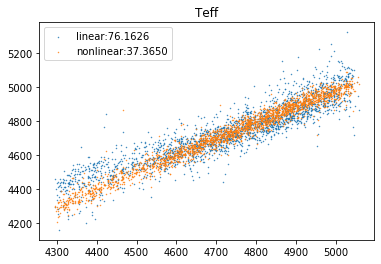

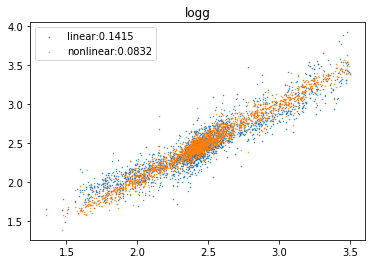

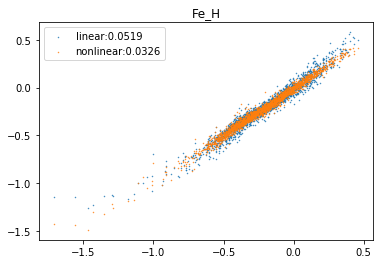

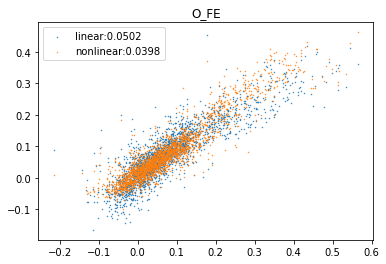

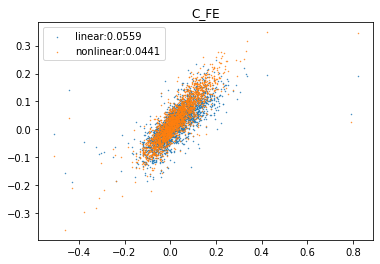

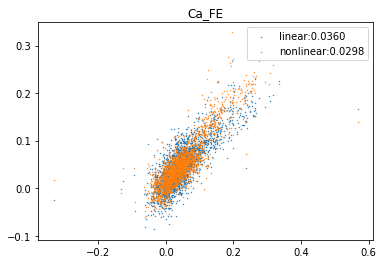

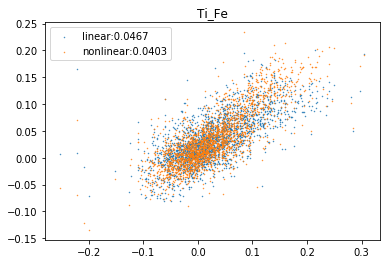

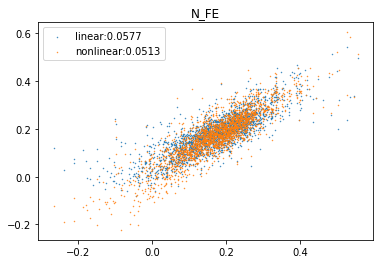

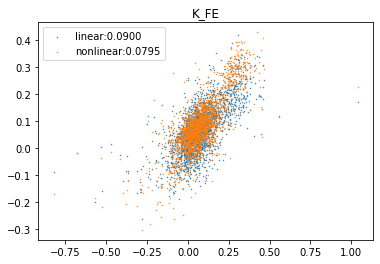

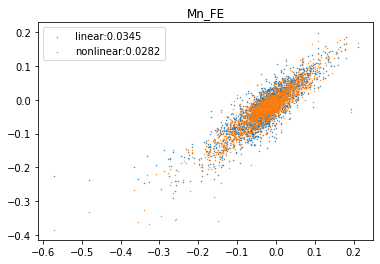

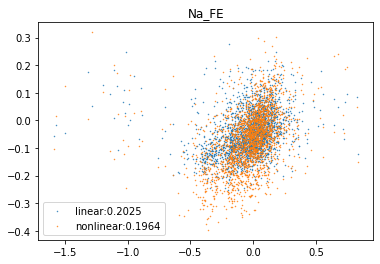

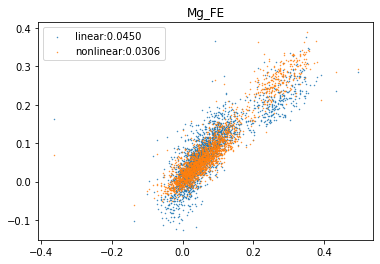

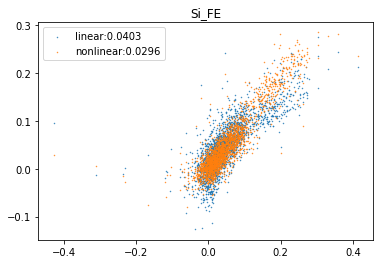

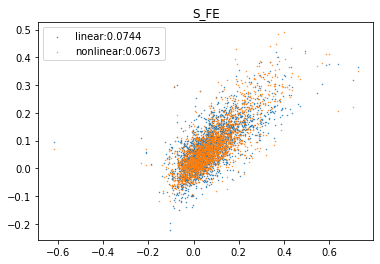

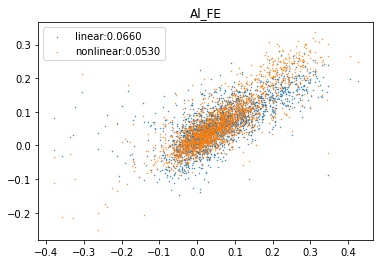

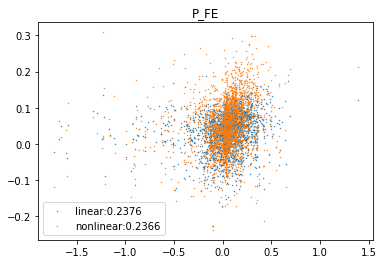

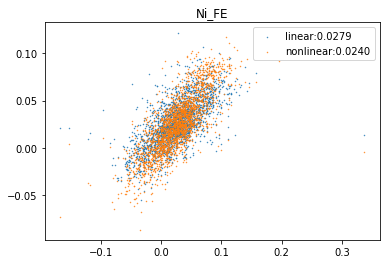

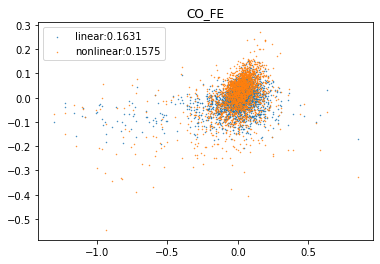

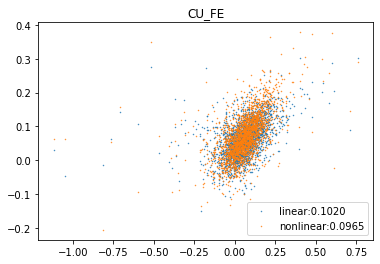

In [16]:
for i in range(len(considered_parameters)):
    plt.title(considered_parameters[i])
    nonlinear_std = np.std(nonlinear_w.predict(z_cut_val).raw[:,i]-y_val.raw[:,i])
    linear_std = np.std(w.predict(z_cut_val).raw[:,i]-y_val.raw[:,i])

    plt.scatter(y_val.raw[:,i],w.predict(z_cut_val).raw[:,i],s=0.2,label="linear:{:.4f}".format(linear_std))
    plt.scatter(y_val.raw[:,i],nonlinear_w.predict(z_cut_val).raw[:,i],s=0.2,label="nonlinear:{:.4f}".format(nonlinear_std))
    plt.legend()
    plt.show()

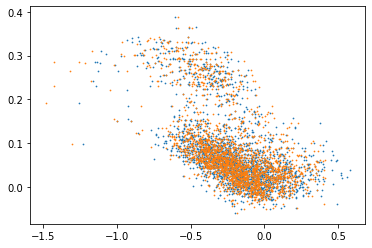

In [36]:
#considered_parameters[11]
#plt.scatter(y_val.raw[:,2],y_val.raw[:,11],s=0.5)
plt.scatter(w.predict(z_cut_val).raw[:,2],nonlinear_w.predict(z_cut_val).raw[:,11],s=0.5)
plt.scatter(nonlinear_w.predict(z_cut_val).raw[:,2],nonlinear_w.predict(z_cut_val).raw[:,11],s=0.5)

(array([  1.,   0.,   0.,   1.,   0.,   1.,   1.,   0.,   1.,   2.,   0.,
          0.,   1.,   2.,   1.,   1.,   3.,   2.,   4.,   2.,   5.,   9.,
          9.,  14.,  10.,  38.,  48.,  69., 101., 130., 147., 130., 134.,
        138., 157., 154., 164., 150., 136., 105.,  83.,  83.,  67.,  47.,
         31.,  23.,  10.,  17.,   7.,   4.]),
 array([-1.7088616 , -1.6655161 , -1.6221708 , -1.5788254 , -1.53548   ,
        -1.4921346 , -1.4487892 , -1.4054438 , -1.3620983 , -1.318753  ,
        -1.2754076 , -1.2320622 , -1.1887168 , -1.1453714 , -1.102026  ,
        -1.0586805 , -1.0153352 , -0.97198975, -0.92864436, -0.88529897,
        -0.8419536 , -0.7986082 , -0.7552628 , -0.7119174 , -0.66857195,
        -0.62522656, -0.58188117, -0.5385358 , -0.49519038, -0.45184496,
        -0.40849957, -0.36515418, -0.32180876, -0.27846336, -0.23511797,
        -0.19177257, -0.14842716, -0.10508177, -0.06173636, -0.01839096,
         0.02495444,  0.06829984,  0.11164524,  0.15499064,  0.19833604,
 

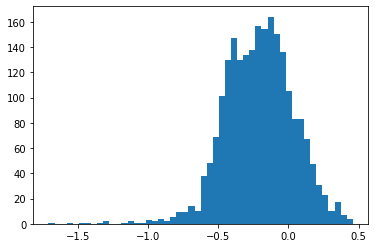

In [24]:
#considered_parameters[11]
plt.hist(y_val.raw[:,2],bins=50)

10000

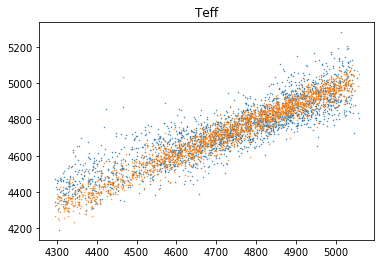

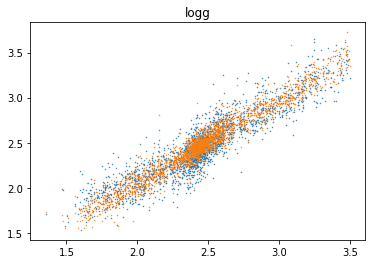

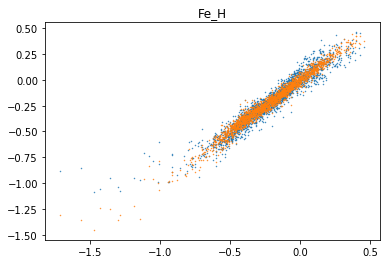

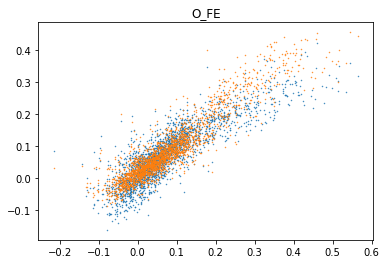

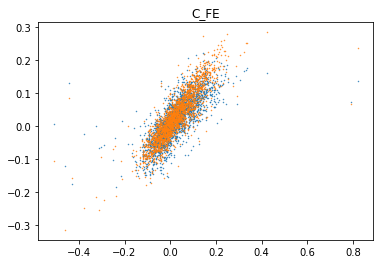

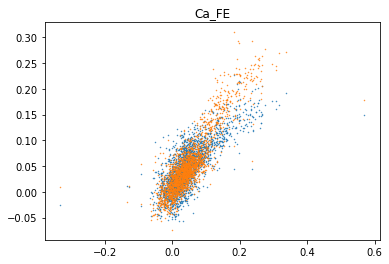

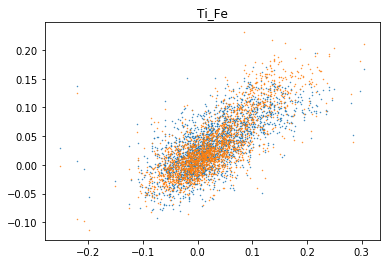

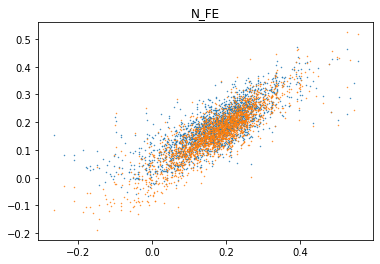

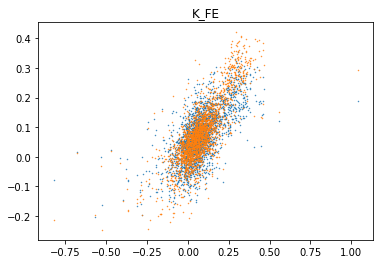

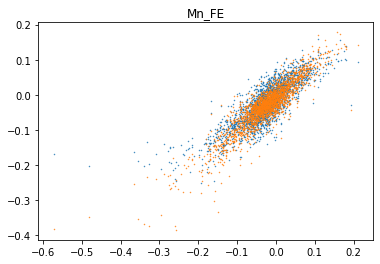

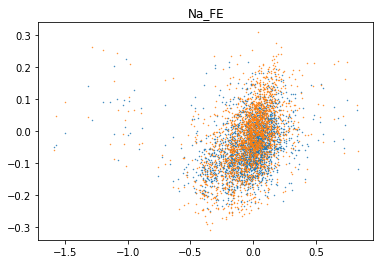

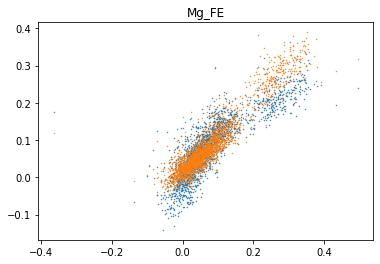

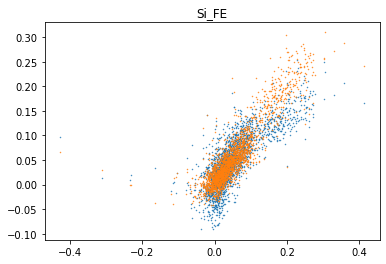

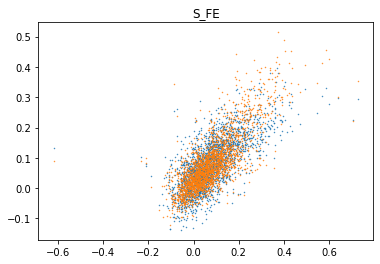

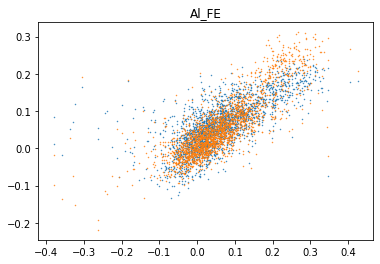

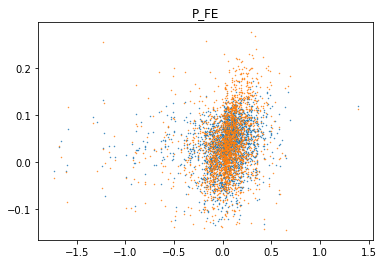

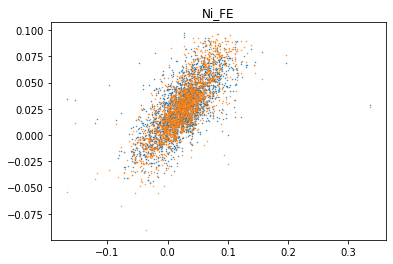

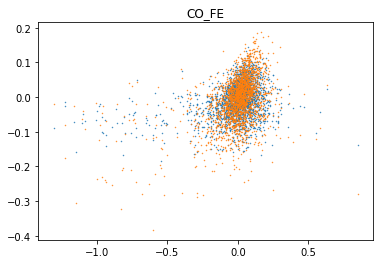

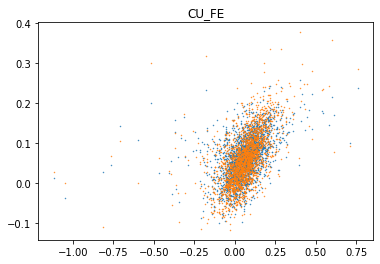

In [18]:
for i in range(len(considered_parameters)):
    plt.title(considered_parameters[i])
    plt.scatter(y_val.raw[:,i],w.predict(z_cut_val).raw[:,i],s=0.2,label="linear")
    plt.scatter(y_val.raw[:,i],nonlinear_w.predict(z_cut_val).raw[:,i],s=0.2,label="linear")
    plt.show()

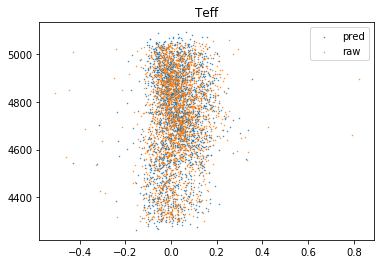

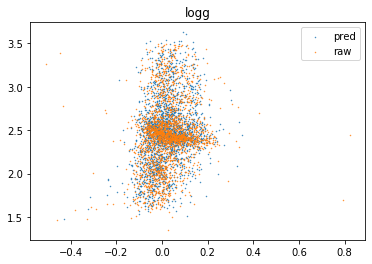

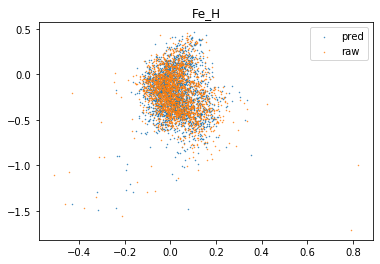

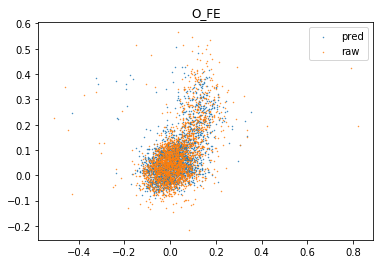

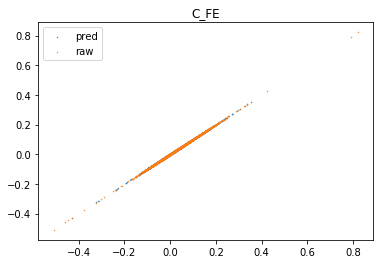

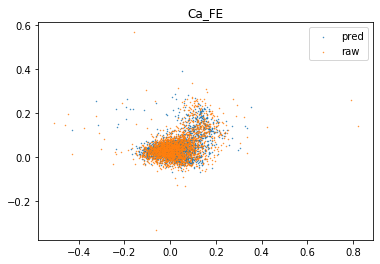

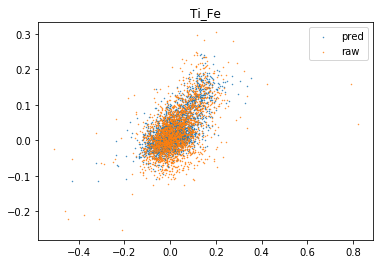

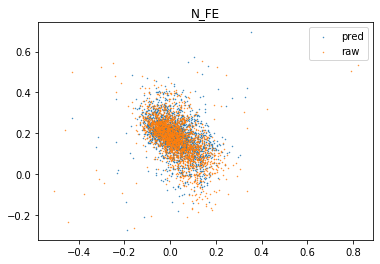

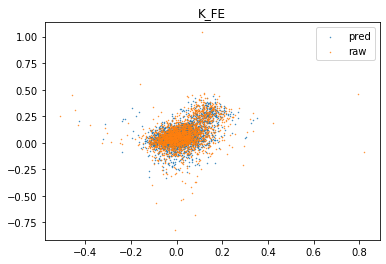

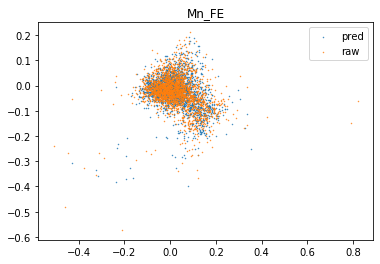

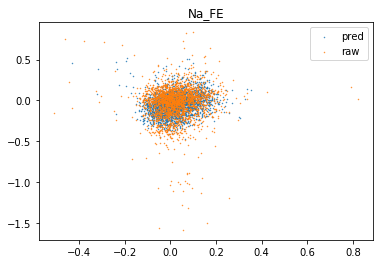

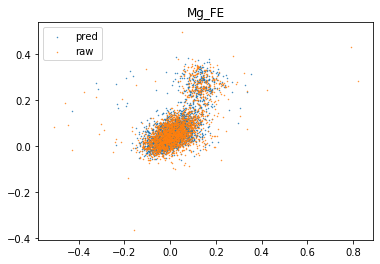

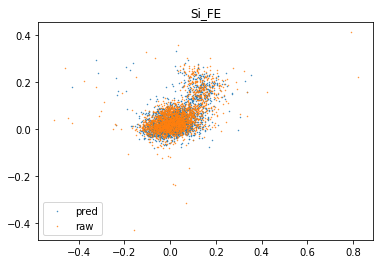

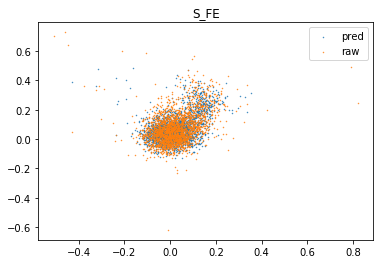

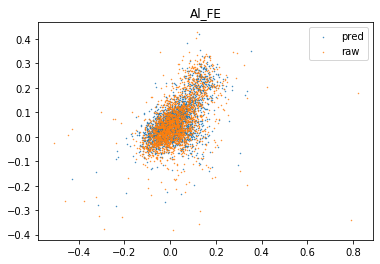

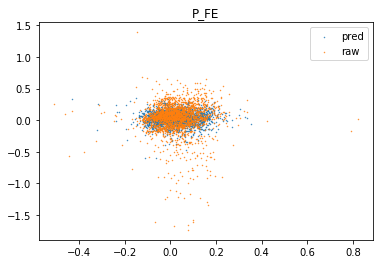

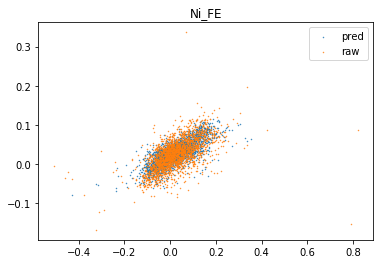

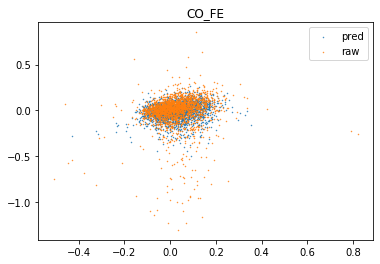

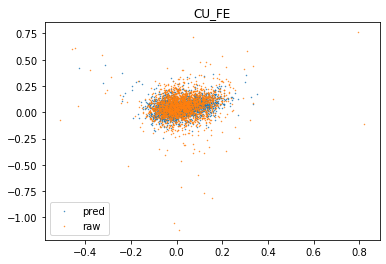

In [297]:
for i in range(len(considered_parameters)):
    plt.title(considered_parameters[i])
    plt.scatter(nonlinear_w.predict(z_cut_val).raw[:,4],nonlinear_w.predict(z_cut_val).raw[:,i],s=0.2,label="pred")
    plt.scatter(y_val.raw[:,4],y_val.raw[:,i],s=0.2,label="raw")
    plt.legend()
    plt.show()

### Comparing quality of fit

In [140]:
spectra_vec = vector.Vector(dataset.dataset["aspcap_interpolated"])


(7430, 7460)

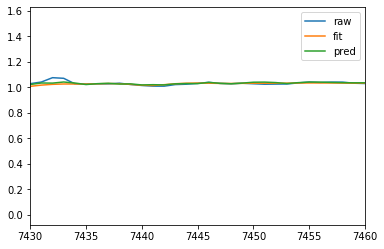

In [174]:
idx  =0
raw = get_aspcap(idx,0)
fit = get_aspcap(idx,3)
err = get_aspcap(idx,2)

plt.plot(raw,label="raw")
plt.plot(fit,label="fit")
x_pred = z.get_x_pred(idx)
plt.plot(x_pred+np.mean(spectra.raw,axis=0),label="pred")

plt.legend()
plt.xlim(7430,7460)

(2000, 2200)

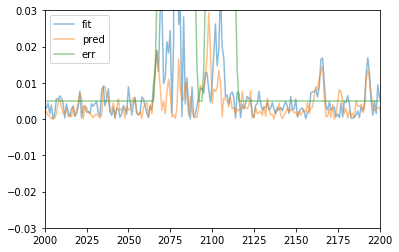

In [199]:
plt.plot(np.abs(raw-fit),label="fit",alpha=0.5)
plt.plot(np.abs(x_pred+np.mean(spectra.raw,axis=0)-fit),label="pred",alpha=0.5)
plt.plot(err,label="err",alpha=0.5)

#x_pred = z.get_x_pred(0)
#plt.plot(x_pred+np.mean(spectra.raw,axis=0),label="pred")

plt.legend()
plt.ylim(-0.03,0.03)
plt.xlim(2000,2200)

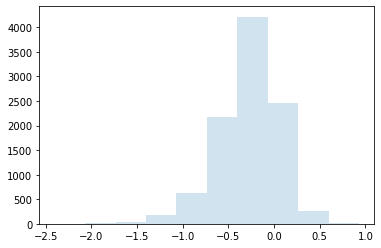

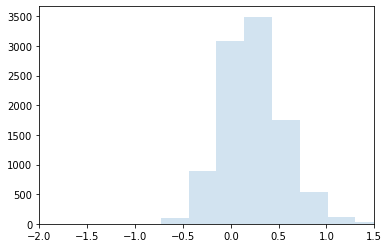

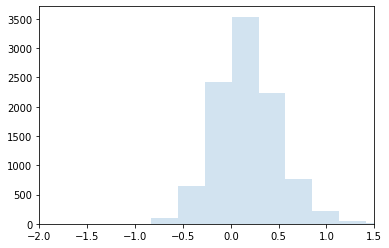

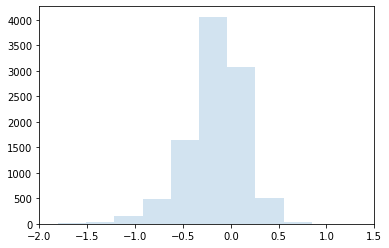

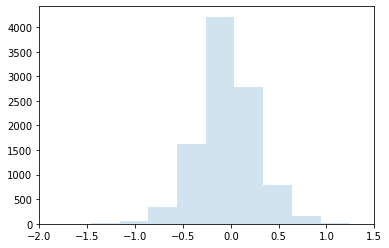

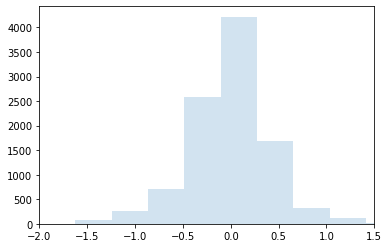

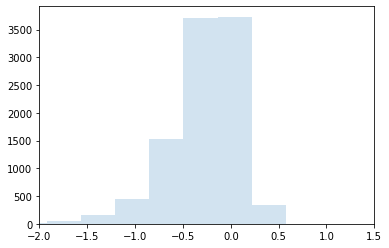

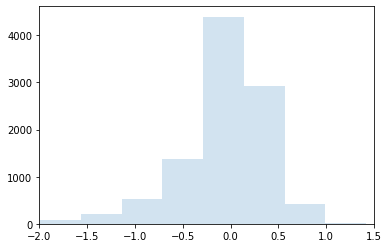

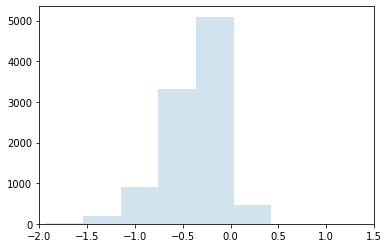

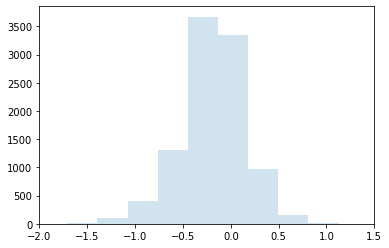

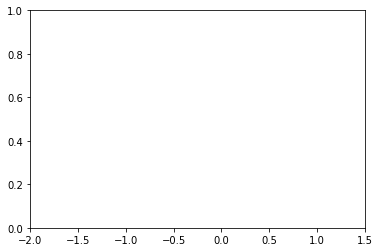

In [203]:
for i in range(10):
    plt.hist(z.raw[:,i],alpha=0.2)
    plt.show()
    plt.xlim(-2,1.5)

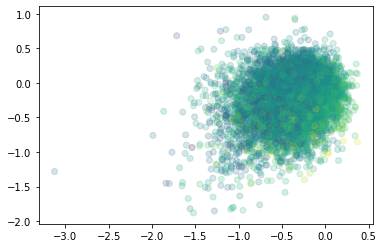

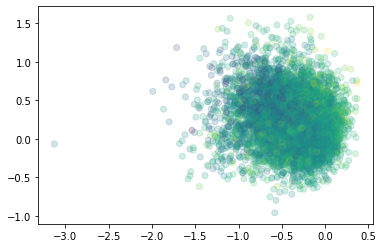

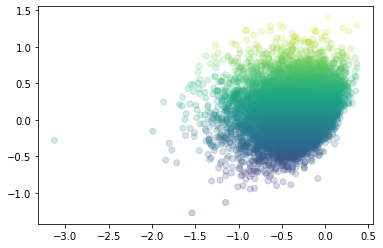

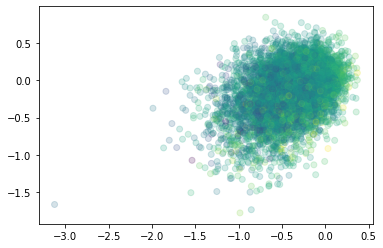

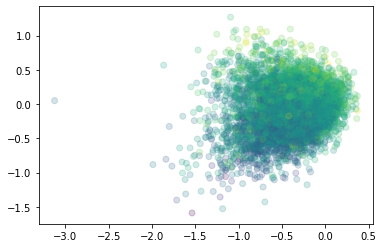

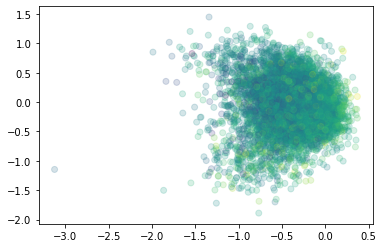

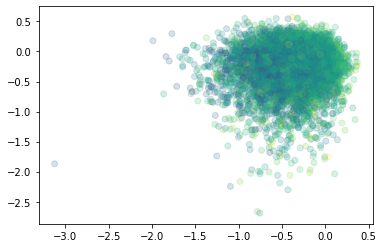

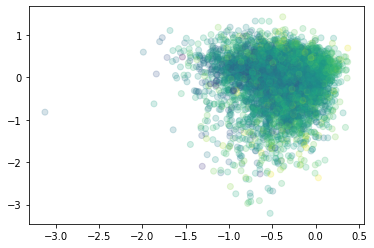

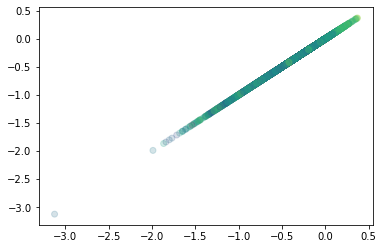

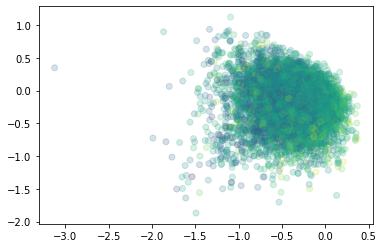

In [310]:
for i in range(10):
    plt.scatter(z.raw[:,8],z.raw[:,i],c=z.raw[:,2],alpha=0.2)
    plt.show()


### Predicting abudances from raw spectra

In [ ]:
y_elem = y.normalized[:,2:3]

In [ ]:
x = dataset.dataset["aspcap"][combined_cut]


In [ ]:
structure = [x.shape[1],1024,512,256,y_elem.shape[1]]
network  = Feedforward(structure,activation=nn.SELU()).to(device)
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(network.parameters(),lr=0.001)
idx_loader = torch.utils.data.DataLoader(np.arange(fe_h.shape[0]),batch_size=100)


In [ ]:
for epoch in range(5000):
    for idx in idx_loader:
        optimizer.zero_grad()
        spec = torch.tensor(x[idx.numpy()]).to(device)
        y_val = torch.tensor(y_elem[idx.numpy()]).to(device)
        y_pred = network(spec)
        err = loss(y_pred,y_val)
        err.backward()
        optimizer.step()
        print(f"err:{err}")


In [ ]:
y

In [ ]:
plt.scatter(y_val.detach().cpu(),y_pred.detach().cpu(),s=0.25)

In [ ]:
loader = iter(idx_loader)

In [ ]:
idx = next(loader)
idx = next(loader)
idx = next(loader)
idx = next(loader)


In [ ]:
fe_network=network

In [ ]:
na_pred = na_network(torch.tensor(x[:10000]).to(device))
plt.scatter(na_pred.detach().cpu(),y.normalized[:10000,5],s=0.3)

In [ ]:
fe_pred = fe_network(torch.tensor(x[:10000]).to(device))
plt.scatter(fe_pred.detach().cpu(),y.normalized[:10000,2],s=0.3)

In [ ]:
plt.scatter(na_pred.detach().cpu(),fe_pred.detach().cpu(),s=0.1)

In [ ]:
plt.scatter(y.normalized[:,2:3],y.normalized[:,5:6],s=0.5)

In [ ]:
import apogee.spec.window as apwindow

In [ ]:
apogee_path.change_dr(12)
start,end = apwindow.waveregions("Si",asIndex=True)

In [ ]:
i = 10
plt.plot(dataset.dataset["aspcap_interpolated"][4])
loc = (end[i]-start[i])/2+start[i]
print(loc)
#plt.arrow(loc,0,loc,0.1,head_width=1, head_length=1)
plt.xlim(start[i]-10,end[i]+10)

In [ ]:
plt.arrow(loc,0,loc,1)
plt.show()

In [389]:
import apogee.tools.read as apread
import apogee.spec.window as apwindow

In [390]:
apwindow.waveregions("Na",asIndex=True)

([5868, 5934], [5887, 5955])

In [392]:
def get_aspcap(idx,ext):
    apogee_id,loc,telescope = dataset.idx_to_prop(idx)
    spec,_ = dataset.get_aspcap(apogee_id,loc,telescope,ext=ext) 
    return spec.astype(np.float32)

In [393]:
allStar= apread.allStar(rmcommissioning=True,main=False,ak=True, akvers='targ',adddist=False)


/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/apogee/tools/read.py:303: RuntimeWarning: Extinction-corrected J,H,K not added because esutil is not installed
  warnings.warn("Extinction-corrected J,H,K not added because esutil is not installed",RuntimeWarning)
